# **CPA attack on chosen Firmware (ANN) deployed on chipwhisperer**

## **2. Capture**

---

### 2.1 Class definition

In [154]:
%run "./ANN_Observer.ipynb"
%run "./File_Uploader.ipynb"

✔️ The Setuper class succesfuly imported.
✔️ The ANN_Observer class succesfuly imported.


### Implementation

⚠️ Changed, firmware config!!!
⚠️ Reinit, initiated!!!
✔️ Firmware maked.
INFO: Found ChipWhisperer😍
✔️ INFO: Scope and Target, are set😍
❤️ Target hex: ./makefile_dir_basic_mult/simpleserial-target-CWLITEARM.hex
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5087 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5087 bytes
✔️ Setuper initiated.
⚠️ The mentioned lab was not found!!!
🕓 Initiating self-creation
⚠️ Generating rand_input..


                                Capturing traces:   0%|          | 0/1500 [00:00<?, ?it/s]

✔️ Project succesfully created.
✔️ Disconection succesfull.
✔️ Saving Rand_input succesfull.
🌍 Saving Secret_weights succesfull.


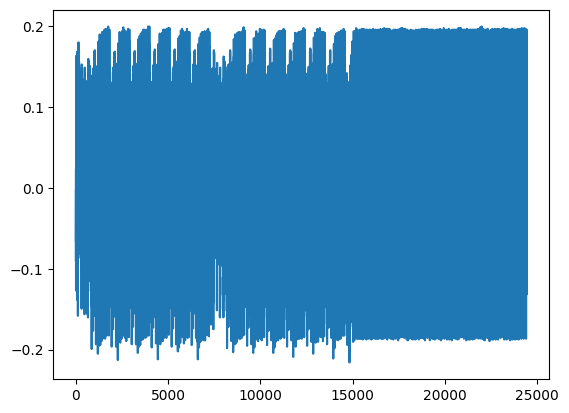

In [160]:
epochs = 1500
make_dir = "makefile_dir_basic_mult"
re_init_config = {"MAKEDIR" : f'./{make_dir}/'}
name = "basic_1500_19_10_2024"
name_extended = f"{name}_{epochs}"
ann_observer = ANN_Observer(_name = f"{name_extended}_traces", _epochs = epochs,
                            create = True, re_init_config = re_init_config, firmware_reinit = True,
                            targ_periodic_reset = False)
ann_observer._scope_disc_()
files = save_data(name_extended = name_extended)

import matplotlib.pyplot as plt
plt.plot(waves[0])

In [127]:
upload_file_to_gdrive(files, dir_path = "database/")

Uploading files::   0%|          | 0/2 [00:00<?, ?it/s]

🌍 
--------- File waves_basic_1000_19_10_2024_1500.npy is Uploaded ----------
🌍 
--------- File rand_inputs_basic_1000_19_10_2024_1500.csv is Uploaded ----------


In [133]:
tmp_waves = ann_observer.project.traces
waves = np.array([i[0] for i in tmp_waves[w_left_border:w_left_border+epochs]])

In [150]:
tenthousand_mutl = waves[0]
cw.plot(tenthousand_mutl)

:Curve   [x]   (y)

In [128]:
thousand_mutl = waves[0]
cw.plot(thousand_mutl)

:Curve   [x]   (y)

In [124]:
one_mult = waves[0]
cw.plot(one_mult)

:Curve   [x]   (y)

In [151]:
cw.plot(tenthousand_mutl) * cw.plot(one_mult)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [147]:
cw.plot(tenthousand_mutl) * cw.plot(thousand_mutl) * cw.plot(one_mult)

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Curve.III :Curve   [x]   (y)

### Analyser

In [51]:
def hamming_weight(x, is_int = True):
    if not is_int:
        return np.count_nonzero(x == 1)
    return bin(x).count("1")
def get_overflowed_val(val = 0, bnum = 8):
    border = 2**(bnum-1)
    if val >= border:
        val = val % (border*2)
        if val >= border:
            val = -border + (val - border)
    return val
def V2_ANN_CPA_OTS(known_input : list, waves = np.array([]), n_traces = 300, trace_len = 24000, ith_weight = 0): # Vanilla ANN CPA, for one time_sample a
    bnum = 8
    corr_all_Tsamples = []
    secret_range = 2**(bnum)
    M = round(secret_range / 2)
    hw = [hamming_weight(secret_value) for secret_value in range(secret_range)]

    qsum_L_list = []
    l_diff_list = []
    for time_sample in range(trace_len):
      L = waves[:,time_sample]
      L_mean = np.mean(L, axis = 0)
      qsum_L = 0
      l_diff = [l - L_mean for l in L]
      for w in range(M*2):
        qsum_L += (l_diff[w])**2
      qsum_L_list.append(qsum_L)
      l_diff_list.append(l_diff)

    # wave_Blen = round(len(waves[0]))
    for secret_value in trange(secret_range, desc='Calculating Correlations for secret key'): # For current WeightHyphothesis do
        corr_Tsamples = []
        H = [] #Hyphotheticalleakage
        for j in range(n_traces):  #  Get an array of possible HammingWeights for current WeightHyphothesis (for all the traces)
            mult_result = (secret_value * known_input[j]) % secret_range
            H.append(hw[mult_result])
        H_mean = np.mean(H, axis = 0)
        h_diff = [h - H_mean for h in H]
        qsum_H = 0
        for w in range(M*2):
          qsum_H += (h_diff[w])**2
        # For current WeightHyphothesis, create an Correlation, this vector needs to be created for each time sample:
        for time_sample in range(trace_len):
            L = waves[:,time_sample]
            l_diff = l_diff_list[time_sample]
            sum_HL = 0
            for w in range(M*2):
              sum_HL += (h_diff[w])*(l_diff[w])
            divider = (qsum_H**(1/2))*(qsum_L_list[time_sample]**(1/2))
            corr = 0
            if divider != 0:
              corr = sum_HL / divider
            corr_Tsamples.append(abs(corr))
        corr_all_Tsamples.append(corr_Tsamples)
    return corr_all_Tsamples
def plot_mult(corr_list, type = "norm"):
  t_corr_list = corr_list.transpose()
  import matplotlib.pyplot as plt
  image = plt.figure()
  for corr in corr_list:
    plt.plot(corr)
  plt.show()
  image.savefig(f'{epochs}_{type}_corr.png')


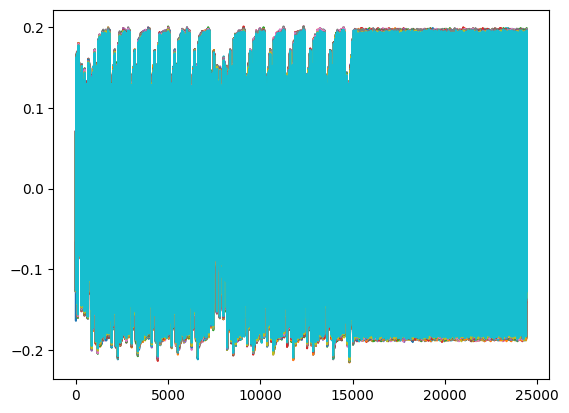

In [121]:
plot_mult(waves[0:50,:], type = "norm")

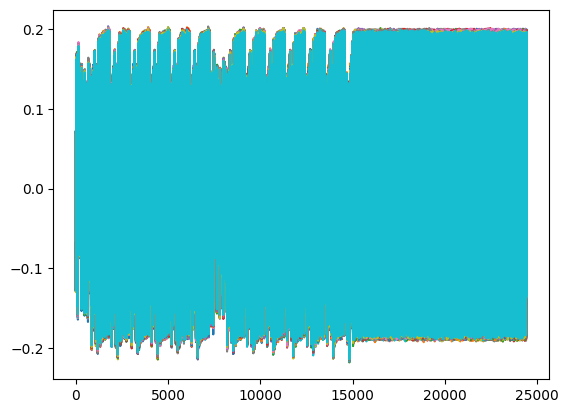

In [71]:
plot_mult(np.array(waves)[0:50,:], type = "norm")

In [89]:
database_waves = waves

Calculating Correlations for secret key:   0%|          | 0/256 [00:00<?, ?it/s]

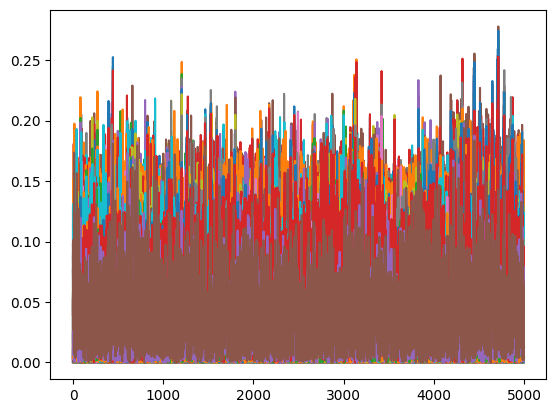

In [90]:
database_waves = waves
ith_weight = 0
start = ith_weight*epochs
ncorr_all = V2_ANN_CPA_OTS(ann_observer.akt_rand_inputs, np.array(database_waves)[start:start+epochs,:], n_traces = epochs, trace_len = 15000, ith_weight = 0)
norm = pd.DataFrame(ncorr_all)
norm.to_csv("corr_all.csv")
plot_mult(np.array(ncorr_all), type = "norm")

### Archive

In [ ]:
    def capture_trace_of(trace_len, input_comp, scope):
        scope_setup(samples=trace_len, decimate=2)
        # flush the UART buffer
        target.flush()
        input_data = bytearray(input_comp * 16)
        target.send_cmd('p', 0x80, input_data)
        ret = scope.capture()
        trace = scope.get_last_trace()
        out_data = target.read_cmd('r')
        print(returned_data)
        ack = target.read_cmd('e')
        print(ack)
        trace = cw.Trace(wave, input_data, out_data, [])
        try:
            assert len(trace) == trace_len
            print("✔️ Trace is of targeted lenght!")
        except AssertionError as msg:
            print("❌ Trace is not of targeted lenght!")
        return trace

## **3. Analysis**

---



In [277]:
from scipy import stats
def V_ANN_CPA_OTS(known_input : list, ann_observer : ANN_Observer, ith_weight = 0): # Vanilla ANN CPA, for one time_sample a
    bnum = 8
    n_traces = ann_observer.epochs
    trace_len = round(ann_observer.trace_len / 2)
    
    corr_all_Tsamples = []
    tmp_waves = ann_observer.project.traces
    w_left_border = ith_weight*n_traces
    waves = [i[0] for i in tmp_waves[w_left_border:w_left_border+n_traces]]
    M = 2**(bnum-1)
    secret_weights = [i for i in range(-M,M)]
    
    # wave_Blen = round(len(waves[0]))
    for i in trange(M*2, desc='Calculating Correlations for secret key'): # For current WeightHyphothesis do
        corr_Tsamples = []
        H = [] #Hyphotheticalleakage
        for j in range(n_traces):  #  Get an array of possible HammingWeights for current WeightHyphothesis (for all the traces)
            mult_result = secret_weights[i] * known_input[j]
            mult_result = get_overflowed_val(mult_result) 
            H.append(hamming_weight(mult_result))
        H_mean = np.mean(H, axis = 0)

        # For current WeightHyphothesis, create an Correlation vector for each Hyphotheticalleakage (in other words for each trace): 
        for time_sample in range(trace_len):
            L = [i[time_sample] for i in waves]
            L_mean = np.mean(L, axis = 0)
            corr = calc_corr(H, H_mean, L, L_mean)
            #corr = stats.pearsonr(H, L).statistic
            corr_abs = abs(corr)
            corr_Tsamples.append(corr_abs)
        corr_all_Tsamples.append(corr_Tsamples)
    return corr_all_Tsamples

In [218]:
import pandas as pd
df = pd.DataFrame(corr_all)
df.to_csv("corr_all_10_5_2024_01W.csv")

In [217]:
corr_all = V_ANN_CPA_OTS(ann_observer.akt_rand_inputs, ann_observer)
import pandas as pd
df = pd.DataFrame(corr_all)
df.to_csv("corr_all_10_5_2024_01W.csv")

Calculating Correlations  for secret key::   0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\Samuel\AppData\Local\Temp\ipykernel_2780\3890672447.py:34: RuntimeWarning: invalid value encountered in scalar divide
  return  cov_val / mult_stds


NameError: name 'pd' is not defined

In [252]:
import scipy
import numpy as np
import pandas as pd
def get_weight(curr_corr, _column_indx = 0):
    #FIND index of highest value for each column (correlation of time sample)
    indx_collumn_max = curr_corr.idxmax()
    #CREATE an array from previous finds
    column_max = [curr_corr[i][indx_collumn_max[i]] for i in range(len(curr_corr))]
    #FIND GLOBAL MAX
    m = max(column_max)
    reduced_indxs = []
    reduced_vals = []
    for i in range(len(column_max)):
        indx = -1
        val = 0
        if column_max[i] + 10 >= m:
            indx = indx_collumn_max[i]
            val = column_max[i]
        reduced_indxs.append(indx)
        reduced_vals.append(indx)
    reduced_vals = np.array(reduced_vals)
    #FIND LOCAL MAXIMAS which are max. 0.1 lesser that global max, and pick the first one
    loc_max_indx_list = scipy.signal.argrelextrema(reduced_vals, np.greater)
    #Final extraction
    time_sample_inxd = loc_max_indx_list[0][0]
    print(loc_max_indx_list)
    print(time_sample_inxd)
    secret_val = indx_collumn_max[time_sample_inxd]
    first_loc_max = column_max[time_sample_inxd]
    return secret_val, first_loc_max, time_sample_inxd, column_max

In [ ]:
df_transposed = pd.DataFrame(corr_all_transposed)
tsecret, tcorr_max, ttime_sample, taggregate_corr = get_weight(df_transposed)

In [253]:
secret, corr_max, time_sample, aggregate_corr = get_weight(df)

(array([  1,   3,   8,  15,  19,  21,  23,  32,  37,  44,  46,  53,  55,
        57,  59,  61,  63,  65,  67,  69,  75,  77,  80,  83,  86,  93,
        95,  97, 101, 105, 110, 113, 116, 120, 123, 125, 136, 138, 141,
       143, 149, 157, 159, 163, 168, 170, 179, 185, 187, 189, 194, 197,
       202, 206, 211, 218, 220, 222, 226, 229, 233, 239, 243, 245, 247,
       252]),)
1


In [269]:
corr_max

np.float64(0.14899242065639873)

In [259]:
cw.plot(corr_all)

:Curve   [x]   (y)

In [254]:
cw.plot(aggregate_corr) * cw.plot(corr_all[secret])

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [262]:
corr_all_transposed = np.transpose(corr_all)

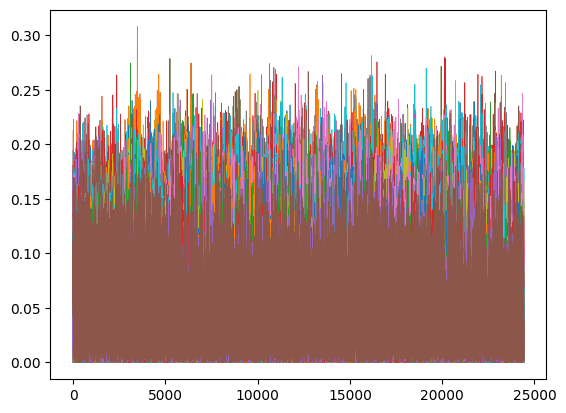

In [263]:
plotSaveWave(wave = corr_all_transposed, name_wave = "corr_all_transposed")

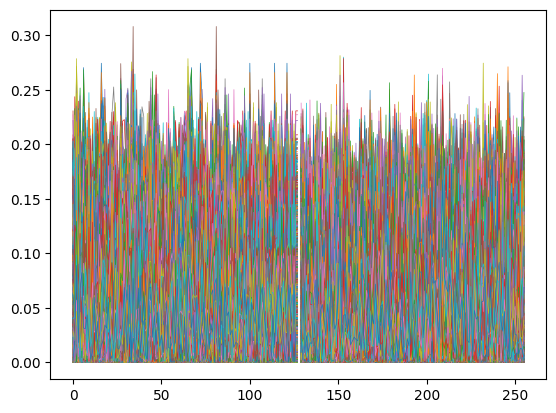

In [260]:
plotSaveWave(wave = corr_all, name_wave = "corr_all")

In [278]:
corr_all_2 = V_ANN_CPA_OTS(ann_observer.akt_rand_inputs, ann_observer)
df = pd.DataFrame(corr_all)
df.to_csv("corr_all_10_6_2024_01W.csv")

Calculating Correlations for secret key:   0%|          | 0/256 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [282]:
rand_inputs = pd.DataFrame(ann_observer.akt_rand_inputs)
rand_inputs.to_csv("rand_inputs_10_8_2024_01W.csv")
tmp_waves = ann_observer.project.traces
w_left_border = 0*300
waves = [i[0] for i in tmp_waves[w_left_border:w_left_border+300]]
df_waves = pd.DataFrame(waves)
df_waves.to_csv("waves_10_8_2024_01W.csv")

In [283]:
tmp_waves = ann_observer.project.traces
w_left_border = 0*300
waves = [i[0] for i in tmp_waves[w_left_border:w_left_border+300]]
df_waves = pd.DataFrame(waves)
df_waves.to_csv("waves_10_6_2024_01W.csv")

### Config

In [12]:
class Config():
    # Param. for chipwhisperer initialization
    hadware_dir = '../../../'
    chipwhisperer_init : dict = {
        "SCOPETYPE" : 'OPENADC',                                                            # Scope type ...

        "MAKEDIR" : './makefile_dir_2/',                                                    # Makefile folder relative path
        "CRYPTO_TARGET" : './',                                                             # Crypto target folder
        "FIRMWAREPATH" : f'{hadware_dir}hardware/victims/firmware',                         # Firmware path, path to compiler, simpleserial of chipwhisperer

        "PLATFORM" : 'CWLITEARM',                                                           # Chipwhisperer device type/Platform
        "SS_VER" :'SS_VER_2_1',                                                             # SimpleSerial version, in this case version 2
        "TARGET" :'simpleserial-target',                                                    # Target name, in this case simpleserial-target
    }

    
    def __init__(self, read_save_project = 'w'):
         pass

### Math Helper

In [255]:
import chipwhisperer.analyzer as cwa
from scipy import stats

def mean(X = []):                             # EQ = np.mean(X, axis = 0)
   return (np.sum(X, axis=0)) / len(X)
def std_dev(X, mean, population = True):      # EQ = np.std(tra, axis = 0) 
    offset = 0
    if not population:
        offset = 1
        
    result = 0
    for  i  in  X:
        result += (i  - mean)**2
    result /= len(X) - offset
    return result**(1/2)
def cov(X, x_mean, Y, y_mean, population = True): # EQ = np.cov(X, Y, bias=True)
    if len(X) != len(Y):
        print("Arrays doesn't have same lenghts!!!")
        return

    offset = 0
    if not population:
        offset = 1
        
    result = 0
    for indx in range(len(X)):
        x = X[indx]
        y = Y[indx]
        result += (x  - x_mean) * (y  - y_mean)
    return result / (len(X) - offset)
def calc_corr(X, x_mean, Y, y_mean):
    #cov_val = cov(X, x_mean, Y, y_mean)
    cov_val = np.cov(X, Y, bias=True)
    mult_stds = np.std(X, axis = 0) * np.std(Y, axis = 0)#  std_dev(X, x_mean) *  std_dev(Y, y_mean)
    return  cov_val / mult_stds

def hamming_weight(x, is_int = True):
    if not is_int:
        return np.count_nonzero(x == 1)
    return bin(x).count("1")
def get_overflowed_val(val = 0, bnum = 8):
    border = 2**(bnum-1)
    if val >= border:
        val = val % (border*2)
        if val >= border:
            val = -border + (val - border)
    return val

### ANN_SCA

In [146]:
class ANN_Analyser():
    bnum = None
    n_traces = None
    trace_len = None
    ann_observer: ANN_Observer = None
    sca_helper: SCA_Helper = None
    self.inputs = []
    
    
    def __init__(self, path, bnum = 8):
        if ann_observer is None:
            raise Exception
        self.bnum = bnum
        self.ann_observer = ANN_Observer(_path = path)
        waves = ann_observer.waves
        self.n_traces = len(waves)
        self.trace_len = len(waves[0])
        self.sca_helper = SCA_Helper()
    
    def __init__(self, ann_observer : ANN_Observer, bnum = 8):
        if ann_observer is None:
            raise Exception
        self.bnum = bnum
        self.ann_observer = ann_observer
        waves = ann_observer.waves
        self.n_traces = len(waves)
        self.trace_len = len(waves[0])
        self.sca_helper = SCA_Helper()




    def V_ANN_CPA_OTS(self, known_input : list): # Vanilla ANN CPA, for one time_sample a
        corr_all_Tsamples = []
        waves = ann_observer.project.traces[0]
        M = 2**(self.bnum-1)
        secret_weights = [i for i in range(-M,M)]
        
        # wave_Blen = round(len(waves[0]))
        for i in trange(M*2, desc='Calculating Correlations  for secret key:'): # For current WeightHyphothesis do
            corr_Tsamples = []
            H = [] #Hyphotheticalleakage
            for j in range(self.n_traces):  #  Get an array of possible HammingWeights for current WeightHyphothesis (for all the traces)
                mult_result = secret_weights[i] * known_input[j]
                mult_result = get_overflowed_val(mult_result) 
                H.append(hamming_weight(mult_result))
            H_mean = mean(H)
    
            # For current WeightHyphothesis, create an Correlation vector for each Hyphotheticalleakage (in other words for each trace): 
            for time_sample in range(self.trace_len):
                L = [i[time_sample] for i in waves]
                L_mean = mean(L)
                
                corr = calc_corr(H, H_mean, L, L_mean)
                corr_abs = abs(corr)
                corr_Tsamples.append(corr_abs)
            corr_all_Tsamples.append(corr_Tsamples)
        return corr_all_Tsamples
    

    def write_read_csv(self, _array, cmd = 'w'):
        import pandas as pd 
        if cmd == 'w':
            df = pd.DataFrame(_array)
            df.to_csv("corr_all.csv")
        elif cmd == 'r':
            try:
                df = pandas.read_csv('corr_all.csv')
                df = df.iloc[: , 1:]
                df = df.fillna(0) 
            except NameError:
              print(f"Error {NameError} occured.")
              print(f"Most propably because the file was not found.")
    # first_row = df.iloc[1, :].to_numpy(copy=True)
    # df["Max_Row_Val"] = df.max( axis='columns' )
    # df["Max_Row_Val_2"] = df.max(axis=0)
    # df

    #### 3.0.1.1 NN CPA
    def SCA_N(self, waves, N_input,  input_len):
        weights = []
        expected_output = 0
        for rand_indx  in  range(input_len):
            # CREATE rand_input , for current weight
            project =  load_project(self, path = f"lab_{self.n_traces}_traces_{rand_indx}")
            known_input = N_input[rand_indx]
            corr_all = self.V_ANN_CPA_OTS(known_input)
            weights.append(#TODO) # append curr_weight, which shoud be a value with highest correlation
        raise NotImplementedError("Add your code here, and delete this.")
        return weights, expected_output

    def calc_next_input(weights, biases, AF = "ReLU"):
        expected_ann_results = []
        if AF == "ReLU":
            pass
        raise NotImplementedError("Add your code here, and delete this.")    


        
    def SCA_ANN_layer(self, waves, NN_input):
        ANNs = []

        akt_layer_corr = 0
        next_layer_corr = -1
        while(akt_layer_corr > next_layer_corr):
            #TODO calc_next_input
            #GET HIGHEST CORR, FOR answer wheter corr, from akt, or next was highest
            akt_layer_corr, next_layer_corr = 
            SCA_N(self, waves, N_input,  self.n_traces)
        raise NotImplementedError("Add your code here, and delete this.")
    def SCA_ANN_vanilla(self, project, ann_input_len = 7):
        for i in range(ann_input_len):
            project, _out_data, _rand_inputs = createXSpecTraces(project_name = "lab_300_traces", rand_input_placement = 0)
        corr_all = V_ANN_CPA_OTS(n_traces = len(waves), waves = waves, known_input = _rand_inputs, trace_len = trace_len)
    
    
        # TODO:
        raise NotImplementedError("Add your code here, and delete this.")

SyntaxError: invalid syntax (1045593155.py, line 89)

### IN WORK

In [1]:
def create_rand_input(curr_formula  = [], rand_len = 300, N_input = 7): # create an array of rand_inputs arrays
    raise NotImplementedError("Add your code here, and delete this.")
    


def calc_formula(curr_formula = [], last_secret = []): # last_formula (calculated from last iteration), 0-th. formula: 0 = w_0*i_0 + ... + w_(n-1)*i_(n-1) + w_n  (w_n == bias)
    #  each element  of incoming formula, needs to  be incremented/or otherviese ...,
    #  with formula of corresponding neuron,  such as e_m (element on  index),  needs to  be incremented  by  formula  of n_m  (m-th neuron of last  layer)  
    raise NotImplementedError("Add your code here, and delete this.")


def get_weight(curr_corr, _column_indx = 0):
    coll_max = idxmax(curr_corr)
    max_corr = -1
    max_indx = -1

    column_indx = column_indx
    max_colm = 0
    for i in range(_column_indx, coll_max):
        if max_corr < curr_corr[i]:
            max_corr = curr_corr[i]
            max_indx = i
            max_colm = column_indx
        column_indx += 1
        # TODO VISUALIZE
    return max_indx, max_corr, max_colm

    def SCA_N(rand_inputs = None, N_input = 0,  input_len = 0):
        # QUESTION 4. What do I need to do to have z < -1 (this shoud be task of formula)
        secrets = []
        curr_corr = []
        last_indx = 0
        for i in range(N_input):
            waves = self.waves_arr[i]
            if rand_inputs is not None:
                waves = []
                ___, ___, ___, waves = self.ann_observer.create_project(self.scope, self.target, project_name = "tmp1",
                                                         num_traces = self.n_traces, bnum = self.bnum, input_size = N_input, rand_indx = i,
                                                                            rand_input = rand_inputs[i])
            corr_all = self.V_ANN_CPA_OTS(known_input, waves)
            secret, ___, column_index = get_weight(corr_all)
            
            curr_corr.append(corr_all[secret])
            secrets.append(secret)
            if last_indx < column_index:
                last_indx = column_index
        return curr_corr, secrets, h0_index

    

    def SCA_ANN_layer(self, bnum, rand_inputs, last_formula):
        curr_secret =  [] # an array of arrays  of weights,  or  otherwise an  matrix, of size,  d_m-1 x  k_m  where m is lenght of currently finding array, and m-1 is lenght of the previous  one
        h0_corr = 0 # highest correlation done on Hyphothesis 0.: That currently proccesed neuron is of current layer, and as such all his inputs, are from results of previous layer 
        
        h1_corr = -1 # highest correlation done on Hyphothesis 1.: That currently proccesed neuron is of next Layers, and as such all his inputs, are from results of current layer 
        
        curr_index = 0
        curr_formula = last_formula
        curr_rand = rand_inputs
        while(h0_corr > h1_corr and curr_index < self.trace_len):                # QUESTION 3. What need the neuron extraction?
            # Neuron extraction needs: bnum, rand_inputs
            h1_formula =  calc_formula(curr_formula, curr_secret) # calculate the formula based  on H1
            h1_rand_input = create_rand_input(h1_formula, self.n_traces)
            h0_corr, h0_secrets, h0_index = self.SCA_N(rand_inputs = None, N_input,  self.n_traces)
            h1_corr, h1_secrets, h1_index = self.SCA_N(rand_inputs = h1_rand_input, N_input,  self.n_traces)
            if h1_corr > h0_corr:
                curr_secret.append(h0_secrets)
                curr_index = curr_index
            else:
                curr_secrets.append(h1_secrets)
                curr_index =  h1_index
                curr_formula = h1_formula
                curr_rand = h1_rand_input
        return curr_secrets, curr_rand, curr_formula, curr_index


    def SCA_ANN_vanilla(self, project, ann_input_len = 7, bnum = 8): # NOT-KNOWN ---> N_of_Layers, N_of_NNs_in_layer, W for each N
                                                                                 # FIRST QUESTION? HOW MANY LAYERS, or in other words when to stop?
        self.last_indx = 0 # value returned by the function of get layer
        self.layer_secret = [] # an array of arrays of values (weights and bias)
        self.last_formula = [1 for _ in range(ann_input_len)]
        L = range((2**bnum)-1) # Range of generated rand_numbers
        rand_inputs = [random.choice(L) for _ in range(num_traces)]
        
        while(last_index <  len(trace) ):
            self.arch_rand_input.append(rand_inputs)
            self.arch_rand_last_formulas.appned(last_formula)
                                                                                 # QUESTION what do I need to send to the layer extraction?
            # <--- bnum, and array_of_inputs (from last iteration <-- last succesfull rand_inputs from next_layer), last_formula (used to calculate neccesary input for previos layers's \math{a} to result in )
            # the formula has to have an N unknown variables, if N is number of inputs in input layer
            tmp_secret_arr, self.rand_inputs, self.last_formula, self.last_indx = SCA_ANN_layer(bnum, rand_inputs, last_formula)
            self.layer_secret.append(tmp_secret_arr)
        return self.layer_secret

SyntaxError: positional argument follows keyword argument (2571208899.py, line 64)

#### Archive

In [14]:
#### 3.0.1.2 Weight Acquisition
def hyphothetical_leakage_calc(secret_interval = None, weight_bnum = 8, inputs = [0]):
    N_poss = 2**(weight_bnum-1)-1                                                  #calc number of possible secret key vals
    poss_secret_vals = []
    mult_results = []
    HW_guesses = []

    if secret_interval is None:                                                    #in case that i will want to input my own interval, such as -2 to 2, including -1.99, -1.98,...,1.98,1.99
        for offset in range(-N_poss, N_poss+1):                                    #generate all possible secret vals into an vector
            poss_secret_vals.append(offset)
        
    
    mult_results = np.outer(poss_secret_vals, inputs)                              #generate multiplication resuls of secret value and known input

    applyall = np.vectorize(hamming_weight)
    HW_guesses = applyall(mult_results)                                            #aply on generated matrix an Hamming weight calc function
    return HW_guesses, mult_results, poss_secret_vals 

# bnum = 8
# inputs = [1,3]
# HW, ___, ___ = hyphothetical_leakage_calc(weight_bnum = bnum, inputs = inputs)
def CPA_ANN(n_traces = 1000, waves = [cw.Trace[0]], bnum = 8, known_input = [0]):
    corr_all_secret = []
    HW, _, secre_weights = hyphothetical_leakage_calc(bnum, known_input)
    for i in range(2**bnum):
        HW_curr_secret = HW[i] #get HW vector, corresponding to current possible secret weight, and all rand inputs () 
        corr_curr_secret, _ = stats.pearsonr(HW_curr_secret, waves)
        corr_all_secret.append(abs(corr_curr_secret))
    return corr_all_secret

def V_CPA_ANN(n_traces = 1000, waves = [cw.Trace[0]], bnum = 8, known_input = [0], trace_len = 1):  #currently only for one wave corr_all_secret = []
    waves_n = []
    for i in waves:
        waves_n.append(normalize_trace(i, treshold = 0.05))
    L = []

    
    secret_weights = []
    M = 2**(bnum-1)
    for offset in range(-M, M):
        secret_weights.append(offset)

    
    corr_all_Tsamples = []
    for i in trange(M*2, desc='Calculating Correlations  for secret key:'): # For current WeightHyphothesis do
        corr_Tsamples = []
        H = [] #Hyphotheticalleakage
        for j in range(n_traces):  #  Get an array of possible HammingWeights for current WeightHyphothesis (for all the traces)
            #print(f"i: {i} j:{j} len_i {len(secret_weights)} len_j {len(known_input)}")
            mult_result = secret_weights[i] * known_input[j]
            mult_result = get_val_after_overflow(mult_result) 
            H.append(hamming_weight(mult_result))
        H_mean = mean(H)

        # For current WeightHyphothesis, create an Correlation vector for each Hyphotheticalleakage (in other words for each trace): 
        for time_sample in range(trace_len):
            L = []
            curr_sample = time_sample * bnum
            for i in waves_n:
                L.append(hamming_weight(i[curr_sample:curr_sample+bnum], is_int = False))
            L_mean = mean(L)
            
            corr = calc_corr(H, H_mean, L, L_mean)
            corr_abs = abs(corr)
            corr_Tsamples.append(corr_abs)
        corr_all_Tsamples.append(corr_Tsamples)
            
    return corr_all_Tsamples

#### *3.0.2. First analysis for SPA plots* 

In [28]:
diff_avg, avg_wave, var, waves = createDiffWave(project)

In [1]:
import matplotlib.pyplot as plt
# Plot the trace
def plotSaveWave(linewidth=0.5, wave = [], name_wave = "wave"):
    #%matplotlib notebook
    fig = plt.figure()
    plt.plot(wave, linewidth=linewidth)
    plt.savefig(f'figures/{name_wave}.svg', format='svg')
    plt.show()
    #plt.close()

In [30]:
cw.plot(avg_wave)

:Curve   [x]   (y)

In [31]:
cw.plot(diff_avg)

:Curve   [x]   (y)

In [32]:
cw.plot(avg_wave) * cw.plot(diff_avg)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [33]:
cw.plot(diff_avg - avg_wave)

:Curve   [x]   (y)

In [34]:
#cw.plot(project.traces[0][0] - avg_wave)

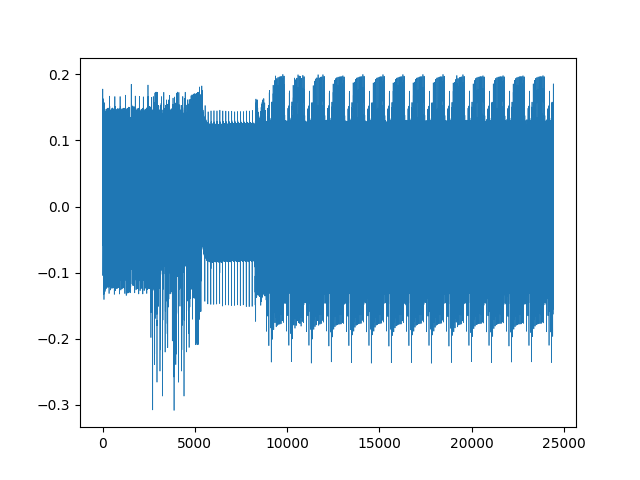

In [35]:
plotSaveWave(wave = avg_wave, name_wave = "avg_wave")

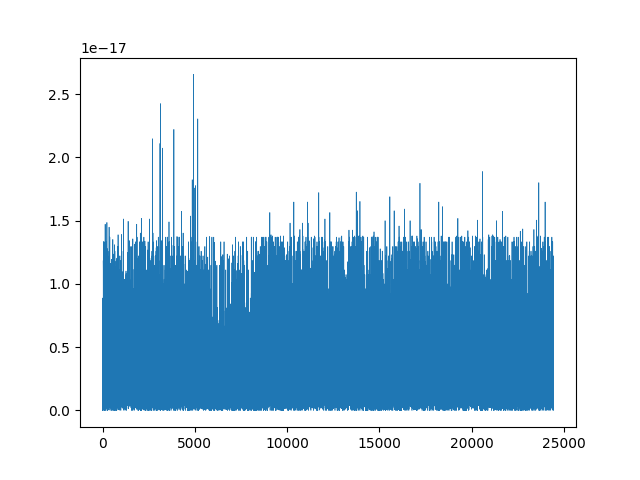

In [36]:
plotSaveWave(wave = abs(diff_avg), name_wave = "diff_avg")

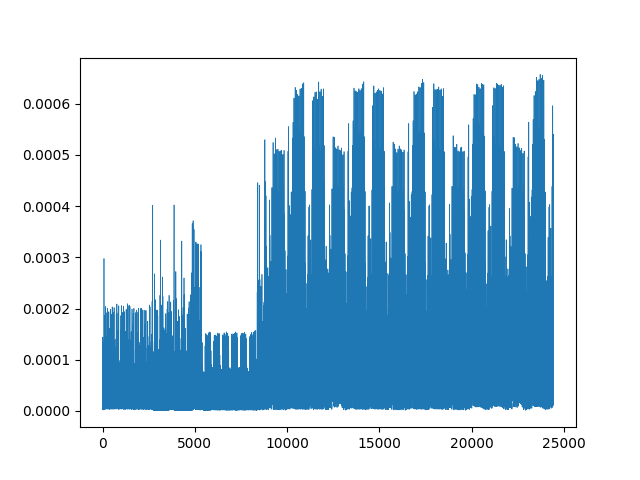

In [37]:
plotSaveWave(wave = var, name_wave = "var")

## TODO

In [119]:
bnum = 16
rand_num = 1000
POSSIBILITIES = 2 ** bnum
possible_input_range = 256

possible_weights_interval = None
rand_input = random.randint(possible_input_range, size=(rand_num))
intermeadiate_guesses = None
HW_guesses = None

In [120]:
print(POSSIBILITIES)

65536


In [121]:
if possible_weights_interval is None:
    possible_weights_interval = []
    for offset in range(POSSIBILITIES):
        possible_weights_interval.append(offset)
if intermeadiate_quesses is None:
    intermeadiate_guesses = np.outer(possible_weights_interval[0:possible_input_range], possible_weights_interval)

In [122]:
applyall = np.vectorize(hamming_weight)
HW_guesses = applyall(intermeadiate_guesses)

In [124]:
HW_guesses = res

In [20]:
bnum = np.array([1,2,3,4])
we_q = np.array([1,2,3,4])

temp = np.outer(bnum,we_q)

print(temp)

[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]]


In [4]:
class AES256_Round13_Model(cwa.AESLeakageHelper):
    def leakage(self, pt, ct, guess, bnum):
        # You must put YOUR recovered 14th round key here.
        # This example may not be accurate!
        calc_round_key = [0xea, 0x79, 0x79, 0x20, 0xc8, 0x71,
                          0x44, 0x7d, 0x46, 0x62, 0x5f, 0x51,
                          0x85, 0xc1, 0x3b, 0xcb]
        xored = [calc_round_key[i] ^ pt[i] for i in range(0, 16)]
        block = xored
        block = self.inv_shiftrows(block)
        block = self.inv_subbytes(block)
        block = self.inv_mixcolumns(block)
        block = self.inv_shiftrows(block)
        result = block
        return self.inv_sbox((result[bnum] ^ guess[bnum]))

class Quantized_ANN_Weight_Model():
    weight_quesses = None
    intermediate_quesses = None
    def leakage(self, guess, bnum): #bnum bite number, guess is an array of quesses
        if weight_quesses is None:
            temp_weight_guesses = []
            int weight_guess = 0
            for offset in range bnum ** 2:
                weight_guess += int(weight_guess + offset)offset
                temp_weight_guesses.append(hex(weight_quess))
            self.weight_quesses = temp_weight_guesses
        if intermediate_quesses is None:    
            self.intermediate_guesses = np.array(self.weight_quesses, input_integers)
        HW = [popcount_py(self.intermediate_guesses[known_input][i] for i in bnum**2])]
        return HW
        
    
    def popcount_py(x):
        return bin(x).count("1")

        
        #TODO return an array of HW(weight_j * input), which contains J weight guesses
        return hamming_weights

leak_model = cwa.leakage_models.new_model(Quantized_ANN_Weight_Model)

SyntaxError: invalid syntax (3013587290.py, line 23)

### *3.0. Trace preprocesing*

---



### *3.1. Analysis setup*

---



In [ ]:
import chipwhisperer.analyzer as cwa
#pick right leakage model for your attack
leak_model = cwa.leakage_models.new_model(ANN_Weight_Model)
attack = cwa.cpa(project, leak_model)
results = attack.run(cwa.get_jupyter_callback(attack))

### *3.2. LASCAR Quick Setup*

---



In [ ]:
import chipwhisperer.common.api.lascar as cw_lascar
from lascar import *
cw_container = cw_lascar.CWContainer(project, project.textins)
cpa_engines = [CpaEngine("cpa_%02d" % i, cw_lascar.sbox_HW_gen(i, range(256)) for i in range(16)]
session = Session(cw_container, engines=cpa_engines).run(batch_size=50)

### *3.3 Implementatio*

---



In [ ]:
import chipwhisperer.analyzer as cwa
disp = cw_lascar.LascarDisplay(cpa_engines, list(project.keys[0]))
disp.show_pge()